# 对抗性示例生成

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt

# NOTE: 这是在下载 MNIST 数据集时绕过“用户代理”限制的方式，具体参考
#       https://github.com/pytorch/vision/issues/3497 
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

本教程将讨论输入参数，定义受到攻击的模型，然后编写攻击代码并运行一些测试。

## 输入

- `epsilons`：用于运行的 $\epsilon$ 值的列表。在列表中保持 0 是很重要的，因为它代表原始测试集上的模型性能。而且，直观地，可以预期 $\epsilon$ 越大，扰动就越明显，但就降低模型精度而言，攻击就越有效。由于数据范围是 $[0, 1]$，故而设置 $0 \leq \epsilon \leq 1$。
- `pretrained_model`：预训练的 MNIST 模型，该模型是用 [pytorch/examples/MNIST](https://github.com/pytorch/examples/tree/master/mnist) 训练的。
- `use_cuda`：布尔标志，使用 CUDA，如果需要和可用。注意，带有 CUDA 的 GPU 对于本教程来说并不重要，因为 CPU 不会花费太多时间。

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda = True

## 受到攻击的模型

如上所述，受到攻击的模型与 [pytorch/examples/MNIST](https://github.com/pytorch/examples/tree/master/mnist) 中的 MNIST 模型相同。您可以训练并保存自己的 MNIST 模型，也可以下载并使用提供的模型。这里的网络定义和测试数据加载器是从 MNIST 示例复制的。本节的目的是定义模型和数据加载器，然后初始化模型并加载预训练的权重。

In [3]:
# 定义 LeNet 模型
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST 测试数据集和 dataloader 声明
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# 定义正在使用的设备
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# 初始化网络
model = Net().to(device)

# 加载预训练模型
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# 将模型设置为评估模式。在本例中，这是 Dropout 层
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## FGSM 攻击

定义通过扰动原始输入来创建对抗示例的函数。`fgsm_attack` 函数有三个输入：原始干净图片 $x$、像素级扰动量 $\epsilon$ 和损失函数对输入图片的梯度（$\nabla_{x} L(x,y,\theta)$） `data_grad`，该函数然后创建受干扰图像（perturbed image）为

$$
\operatorname{perturbed\_image} = x + \epsilon \operatorname{sign}(\nabla_{x} L(x,y,\theta))
$$

最后，为了保持数据的原始范围，对扰动后的图像剪切到 $[0, 1]$。

In [4]:
# FGSM 攻击代码
def fgsm_attack(image, epsilon, data_grad):
    # 收集数据梯度的元素符号
    sign_data_grad = data_grad.sign()
    # 通过调整输入图像的每个像素来创建摄动图像
    perturbed_image = image + epsilon*sign_data_grad
    # 添加剪切以保持 [0,1] 范围
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 返回受干扰图像
    return perturbed_image

## 测试函数

In [5]:
def test( model, device, test_loader, epsilon ):
    # Accuracy 计数器
    correct = 0
    adv_examples = []

    # 遍历测试集中的所有示例
    for data, target in test_loader:
        # 将数据和标签发送到设备
        data, target = data.to(device), target.to(device)
        # 设置张量的 requires_grad 属性。对攻击很重要
        data.requires_grad = True
        # 模型前向传递数据
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 得到最大对数概率的索引
        # 如果最初的预测是错误的，不要费事攻击，继续前进
        if init_pred.item() != target.item():
            continue
        # 计算损失
        loss = F.nll_loss(output, target)
        # 清零所有现有的梯度
        model.zero_grad()
        # 计算模型反向传递的梯度
        loss.backward()
        # 收集 datagrad
        data_grad = data.grad.data
        # 回调 FGSM 攻击
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # 对扰动图像重新分类
        output = model(perturbed_data)
        # 检查是否成功
        final_pred = output.max(1, keepdim=True)[1] # 得到最大对数概率的索引
        if final_pred.item() == target.item():
            correct += 1
            # 保存 0 epsilon 的样例的特殊情况
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 保存一些 adv 示例以便以后可视化
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    # 计算这个 epsilon 的最终精度
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    # 返回精度和对抗样本
    return final_acc, adv_examples

## 运行攻击

In [6]:
accuracies = []
examples = []

# 对每个 epsilon 运行测试
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4300 / 10000 = 0.43
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 868 / 10000 = 0.0868


## 结果

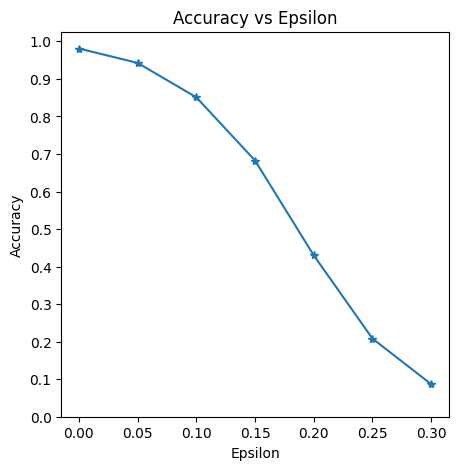

In [7]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

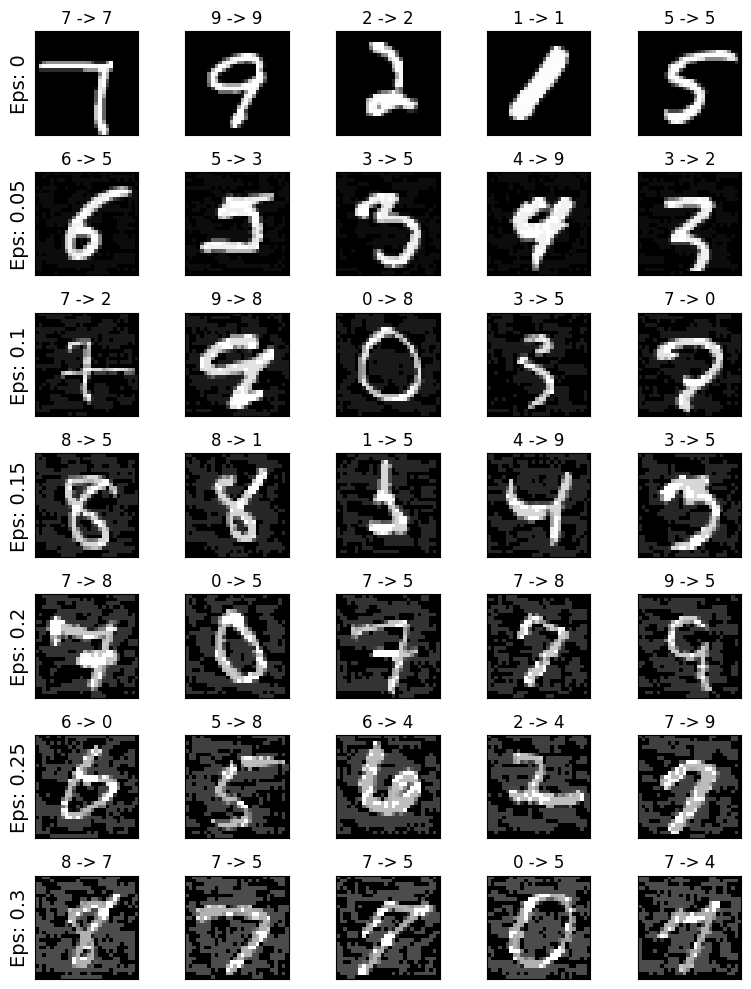

In [8]:
# 在每个 epsilon 上画几个对抗样本的例子
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()